In [17]:
import json
from collections import Counter
import os

In [18]:
import json
import os
import ast
from collections import Counter

def count_files(dir, type_file:str):
    list_of_jsons = []
    for file in os.listdir(dir):
        if file.endswith(".json"):
            with open(os.path.join(dir, file), 'r') as f:
                list_of_jsons.append(json.load(f))
    total_files = 0
    for jsn in list_of_jsons:
        total_files += 1
    print(f"Total files in folder {type_file}: {total_files}")
    return total_files

def explore_mailex(json_list):
    event_counts = Counter()
    argument_counts = {} 
    total_turns = 0
    all_triggers = []

    for jsn in json_list:
        # Check if 'events' exists and is a dictionary
        events_data = jsn.get('events', {})
        for turn_id, turn_events in events_data.items():
            total_turns += 1
            for event_type, info in turn_events.items():
                event_counts[event_type] += 1
                
                # Analyze Triggers Safely
                for trig in info.get('triggers', []):
                    # Check if trig is a non-empty string that looks like a dict
                    if isinstance(trig, str) and '{' in trig:
                        try:
                            # literal_eval is safer than eval
                            t_data = ast.literal_eval(trig)
                            all_triggers.append(t_data.get('words', '').lower())
                        except (SyntaxError, ValueError):
                            continue # Skip malformed strings
                    elif isinstance(trig, dict):
                        all_triggers.append(trig.get('words', '').lower())

                # Analyze Argument Labels
                if event_type not in argument_counts:
                    argument_counts[event_type] = Counter()
                
                # Check labels exist and aren't empty
                labels_list = info.get('labels', [])
                if labels_list:
                    labels = labels_list[0]
                    for lbl in labels:
                        if lbl != "O" and ":B-" in lbl:
                            role = lbl.split(':B-')[1]
                            argument_counts[event_type][role] += 1

    print(f"--- Dataset Summary ---")
    print(f"Total Email Turns: {total_turns}")
    print(f"\n--- Event Distribution ---")
    for ev, count in sorted(event_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{ev:25}: {count}")

    print(f"\n--- Top 10 Trigger Phrases ---")
    for phrase, count in Counter(all_triggers).most_common(10):
        if phrase.strip(): # Don't print empty strings
            print(f"'{phrase}': {count}")

    return argument_counts


# first we check the proportions of train and test
train_files_num = count_files("data/train", "train")
test_files_num = count_files("data/test", "test")
dev_files_num = count_files("data/dev", "dev")
full_files_num = count_files("data/full_data", "full_data")
print()
print("--- Percentages ---")
print(f"Train data: {(train_files_num / full_files_num) * 100:.2f}%\n"
      f"Test data: {(test_files_num / full_files_num) * 100:.2f}%\n"
      f"Dev data: {(dev_files_num / full_files_num) * 100:.2f}%")
print()
# test_dir = 
# train_dir = 'data/train'
# all_files_dir = 'data/full_data'
# list_json_train = []
# list_of_jsons = []
# for file in os.listdir(test_dir):
#     if file.endswith(".json"):
#         with open(os.path.join(test_dir, file), 'r') as f:
#             list_of_jsons.append(json.load(f))


# Corrected Usage
files_dir = "data/train"
list_of_jsons = []

# Added a check to ensure we only load .json files to avoid hidden system files like .DS_Store
for file in os.listdir(files_dir):
    if file.endswith(".json"):
        with open(os.path.join(files_dir, file), 'r') as f:
            list_of_jsons.append(json.load(f))

stats = explore_mailex(list_of_jsons)
# Usage:
# files_dir = "data/train"
# list_of_jsons = [json.load(open(os.path.join(files_dir, file))) for file in os.listdir(files_dir)]
# stats = explore_mailex(list_of_jsons)

print(stats)

Total files in folder train: 1200
Total files in folder test: 150
Total files in folder dev: 150
Total files in folder full_data: 1500

--- Percentages ---
Train data: 80.00%
Test data: 10.00%
Dev data: 10.00%

--- Dataset Summary ---
Total Email Turns: 3117

--- Event Distribution ---
Deliver_Action_Data      : 1252
Deliver_Data             : 1002
Request_Action           : 834
O                        : 636
Request_Data             : 460
Deliver_Meeting_Data     : 312
Request_Meeting          : 194
Request_Action_Data      : 164
Amend_Data               : 119
Amend_Meeting_Data       : 40
Request_Meeting_Data     : 37
Amend_Action_Data        : 2

--- Top 10 Trigger Phrases ---
'let me know': 56
'working': 43
'asked': 42
'please review': 41
'please let me know': 41
'said': 36
'trying': 36
'file :': 35
'is the': 34
'received': 31
{'Request_Data': Counter(), 'Request_Action': Counter({'Action Description': 838, 'Action Members': 540, 'Action Date': 68, 'Request Members': 24, 'Action Ti

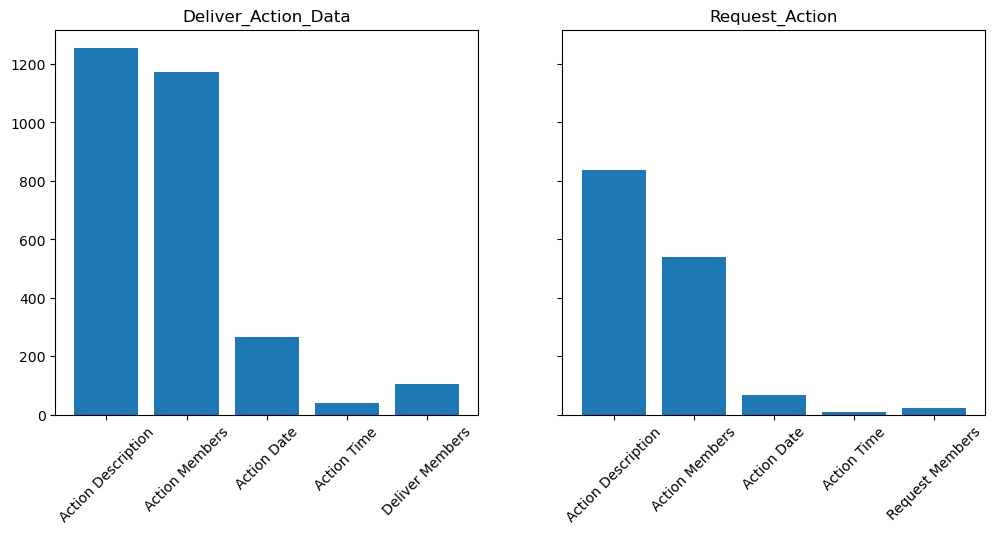

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# this plots the two first plots in 2 axis next to each other using same reference y
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax1.bar(list(stats['Deliver_Action_Data'].keys()), list(stats['Deliver_Action_Data'].values()))
ax1.set_title('Deliver_Action_Data')
ax1.tick_params(axis='x', rotation=45) # --- 1. Prepare Data for Event Distribution ---


# plt.subplot(1, 2, 2, sharey=True)
ax2.bar(list(stats['Request_Action'].keys()), list(stats['Request_Action'].values()))
ax2.set_title('Request_Action')
ax2.tick_params(axis='x', rotation=45)# --- 1. Prepare Data for Event Distribution ---

# event_df = pd.DataFrame(
#     list(stats.keys()), 
#     columns=['Event Type']
# )
# # We need to get the counts we printed earlier into a list
# event_counts = [sum(stats[ev].values()) for ev in stats] 
# # Note: For accuracy, let's use the event_counts from the previous function
# # If you didn't save event_counts globally, we'll re-extract from stats
# event_summary = pd.DataFrame({
#     'Event': list(stats.keys()),
#     'Total Arguments Found': [sum(counts.values()) for counts in stats.values()]
# }).sort_values('Total Arguments Found', ascending=False)

# # --- 2. Prepare Data for Argument Density (Top Event) ---
# top_event = event_summary.iloc[0]['Event']
# arg_data = pd.DataFrame.from_dict(stats[top_event], orient='index', columns=['Count']).reset_index()
# arg_data.columns = ['Argument Role', 'Frequency']
# arg_data = arg_data.sort_values('Frequency', ascending=False)

# # --- 3. Plotting ---
# plt.figure(figsize=(14, 6))

# # Plot A: Event Prevalence
# plt.subplot(2, 2, 1)
# sns.barplot(data=event_summary, x='Total Arguments Found', y='Event', palette='viridis')
# plt.title(f'Event Prevalence\n(By total arguments labeled)', fontsize=14)
# plt.xlabel('Count of Labels')

# # Plot B: Argument Breakdown for the Top Event
# plt.subplot(2, 2, 2)
# sns.barplot(data=arg_data, x='Frequency', y='Argument Role', palette='magma')
# plt.title(f'Argument Distribution for:\n{top_event}', fontsize=14)
# plt.xlabel('Occurrences')

# plt.tight_layout()
# plt.show()

This stores all triggers for a specific event

In [20]:
import ast
from collections import Counter

# Create a list to store all triggers for this specific event
deliver_action_triggers = []

for jsn in list_of_jsons:
    for turn_id, turn_events in jsn.get('events', {}).items():
        # Check if the specific event exists in this turn
        if 'Deliver_Action_Data' in turn_events:
            event_info = turn_events['Deliver_Action_Data']
            
            for trig in event_info.get('triggers', []):
                # Safely parse the string representation of the dict
                try:
                    if isinstance(trig, str) and trig.strip():
                        t_data = ast.literal_eval(trig)
                        phrase = t_data.get('words', '').lower()
                        if phrase:
                            deliver_action_triggers.append(phrase)
                except (SyntaxError, ValueError):
                    continue

# 1. Get the unique list
unique_triggers = sorted(list(set(deliver_action_triggers)))

# 2. Get the frequency distribution
trigger_freq = Counter(deliver_action_triggers)

print(f"Total occurrences of 'Deliver_Action_Data' triggers: {len(deliver_action_triggers)}")
print(f"Unique trigger phrases found: {len(unique_triggers)}")
print("\n--- Top Triggers for Deliver_Action_Data ---")
for phrase, count in trigger_freq.most_common():
    print(f"- {phrase}: {count}")

Total occurrences of 'Deliver_Action_Data' triggers: 2477
Unique trigger phrases found: 1278

--- Top Triggers for Deliver_Action_Data ---
- working: 43
- asked: 42
- said: 36
- trying: 36
- received: 31
- going: 27
- told: 27
- heard: 21
- requested: 20
- looking: 20
- sent: 19
- got: 18
- agreed: 16
- indicated: 15
- found: 15
- done: 13
- made: 13
- will send: 13
- filed: 13
- reviewed: 12
- left: 12
- wanted: 12
- suggested: 12
- will be out: 11
- approved: 11
- will continue: 10
- given: 10
- will get: 10
- gave: 10
- taken: 9
- worked: 9
- included: 9
- forwarded: 9
- will forward: 9
- scheduled: 9
- will let you know: 9
- will be in: 8
- completed: 8
- getting: 8
- will work: 8
- planning: 8
- bought: 8
- checked: 8
- will do: 8
- decided: 8
- says: 8
- is out: 7
- 'll let you know: 7
- provided: 7
- advised: 7
- leaving: 7
- submitted: 7
- moved: 7
- confirmed: 7
- will try: 7
- mentioned: 6
- tried: 6
- expressed: 6
- informed: 6
- went: 6
- added: 6
- contacted: 6
- making: 6

In [21]:
# Create a list to store all triggers for this specific event
deliver_action_triggers = []

for jsn in list_of_jsons:
    for turn_id, turn_events in jsn.get('events', {}).items():
        # Check if the specific event exists in this turn
        if 'Request_Action' in turn_events:
            event_info = turn_events['Request_Action']
            
            for trig in event_info.get('triggers', []):
                # Safely parse the string representation of the dict
                try:
                    if isinstance(trig, str) and trig.strip():
                        t_data = ast.literal_eval(trig)
                        phrase = t_data.get('words', '').lower()
                        if phrase:
                            deliver_action_triggers.append(phrase)
                except (SyntaxError, ValueError):
                    continue

# 1. Get the unique list
unique_triggers = sorted(list(set(deliver_action_triggers)))

# 2. Get the frequency distribution
trigger_freq = Counter(deliver_action_triggers)

print(f"Total occurrences of 'Request_Action' triggers: {len(deliver_action_triggers)}")
print(f"Unique trigger phrases found: {len(unique_triggers)}")
print("\n--- Top Triggers for Request_Action ---")
for phrase, count in trigger_freq.most_common():
    print(f"- {phrase}: {count}")

Total occurrences of 'Request_Action' triggers: 1079
Unique trigger phrases found: 594

--- Top Triggers for Request_Action ---
- let me know: 55
- please let me know: 41
- please review: 40
- please advise: 29
- please forward: 17
- check: 17
- send: 16
- forward: 14
- please confirm: 12
- please send: 10
- confirm: 9
- review: 9
- help me: 9
- please note: 9
- please mark: 9
- please pass: 8
- please contact: 7
- please disregard: 7
- please give: 6
- need to file: 5
- make sure: 5
- proceed: 5
- please move: 5
- please use: 5
- please respond: 5
- get back: 5
- reply: 4
- circulate: 4
- please share: 4
- please provide: 4
- please make: 4
- please e-mail: 4
- please proceed: 4
- please prepare: 4
- please get: 4
- please adjust: 4
- pls advise: 4
- return: 3
- look: 3
- choose: 3
- please work: 3
- notify: 3
- ensure: 3
- please see: 3
- please help: 3
- need to make: 3
- put: 3
- please fill: 3
- please ask: 3
- please set up: 3
- advise: 3
- please coordinate: 3
- contact: 3
- ask

In [22]:
# import matplotlib.pyplot as plt

# # 1. Calculate the total count of arguments for every event found
# # This tells us which events actually have labels
# event_totals = {event: sum(args.values()) for event, args in stats.items()}

# # 2. Sort them so the most populated events are on top
# sorted_events = dict(sorted(event_totals.items(), key=lambda item: item[1], reverse=True))

# # 3. Create the "Normal" Bar Plot
# plt.figure(figsize=(10, 6))
# plt.bar(list(sorted_events.keys()), list(sorted_events.values()), color='skyblue', edgecolor='navy')

# # Add labels and formatting
# plt.title("Total Argument Labels Found per Event Type", fontsize=14)
# plt.xlabel("Event Type", fontsize=12)
# plt.ylabel("Total Number of Arguments", fontsize=12)
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Add value labels on top of the bars
# for i, v in enumerate(sorted_events.values()):
#     plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# plt.tight_layout()
# plt.show()

# # 4. Print the keys to verify the exact names
# print("Available Event Types in your dataset:")
# print(list(stats.keys()))